In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Genetic algorithm for hyperparameter optimization on the mnist dataset.
Credits: https://github.com/guibacellar/OpenAi/blob/master/CartPole-GA.py

In [12]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, InputLayer
from keras import backend as K
from keras.utils import to_categorical
from matplotlib import pyplot
import ipywidgets
from gahyparopt import gahyperopt as ga 
from tensorflow.keras.utils import plot_model

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [6]:
# Get test and training data.
data = ga.load_mnist()

In [7]:
@ipywidgets.interact(i=ipywidgets.IntSlider(min=0, max=40000-1, step=100, value=0))
def plot_mnist_figure(i):
    print(data['y_train'][i])
    pyplot.imshow(data['x_train'][i].reshape(28,28), cmap='bone_r')

interactive(children=(IntSlider(value=0, description='i', max=39999, step=100), Output()), _dom_classes=('widg…

In [34]:
def generate_reference_ml():
    """
    Train and Generate NN Model based on https://github.com/fchollet/deep-learning-with-python-notebooks/blobs/master/2.1-a-first-look-at-a-neural-netword.ipynb'
    :param df: Dataframe to Training Process
    :return:
    """

    # Define Neural model Topology
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
    model.add(Dense(10, activation='softmax'))

    # Compile Neural model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    display(plot_model(model, show_shapes=True, show_layer_names=False))
    
    return model

def model_training(model, data):
    run_start = time.time()
    # Fit Model with Data
    x_train, y_train, x_val, y_val = data.values()
    training = model.fit(x_train, y_train,
        epochs=20,
        batch_size=128,
        steps_per_epoch=300,
        verbose=1,
        validation_data=(x_val, y_val),
    )

    run_stop = time.time()
    print(f"Done > Takes {run_stop-run_start} sec")
    
    return model, training



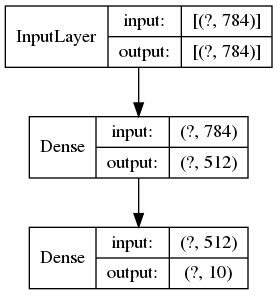

In [35]:
# Creates a Reference NN Model based on 
ml_model = generate_reference_ml()

In [36]:
model, training = model_training(ml_model, data)

Epoch 1/20
300/300 [==============================] - 2s 5ms/step - loss: 0.3143 - accuracy: 0.9102 - val_loss: 0.1742 - val_accuracy: 0.9481
Epoch 2/20
300/300 [==============================] - 2s 5ms/step - loss: 0.1325 - accuracy: 0.9605 - val_loss: 0.1256 - val_accuracy: 0.9622
Epoch 3/20
300/300 [==============================] - 2s 5ms/step - loss: 0.0865 - accuracy: 0.9749 - val_loss: 0.1180 - val_accuracy: 0.9643
Epoch 4/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0616 - accuracy: 0.9818 - val_loss: 0.1006 - val_accuracy: 0.9700
Epoch 5/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0473 - accuracy: 0.9863 - val_loss: 0.0933 - val_accuracy: 0.9741
Epoch 6/20
300/300 [==============================] - 2s 5ms/step - loss: 0.0350 - accuracy: 0.9902 - val_loss: 0.0908 - val_accuracy: 0.9744
Epoch 7/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0260 - accuracy: 0.9928 - val_loss: 0.0961 - val_accuracy: 0.9743
Epoch 

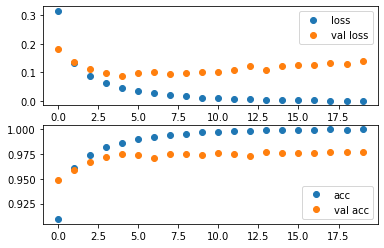

In [31]:
history = pd.DataFrame(training.history)

fig, ax = pyplot.subplots(2,1)
history['loss'].plot(ax=ax[0], style="o",label='loss')
history['val_loss'].plot(ax=ax[0], style="o",label='val loss')
ax[0].legend()
history['accuracy'].plot(ax=ax[1], style="o",label='acc')
history['val_accuracy'].plot(ax=ax[1], style="o",label='val acc')
ax[1].legend()

In [39]:
loss, accuracy = model.evaluate(x=data['x_val'], y=data['y_val'])

625/625 [==============================] - 2s 3ms/step - loss: 0.1333 - accuracy: 0.9786


In [40]:
print(f"Validation loss = {loss}")
print(f"Validation accuracy = {accuracy}")

Validation loss = 0.13332107663154602
Validation accuracy = 0.9785500168800354


## Was sagt das Model eigentlich voraus?

In [119]:
predicted = model.predict(data['x_val'])
expected = data['y_val']

In [120]:
predicted[0]

array([1.1556001e-21, 1.2814851e-16, 6.6451164e-16, 1.1994938e-12,
       5.3290379e-25, 6.0953947e-22, 4.6639137e-32, 1.0000000e+00,
       1.2872364e-17, 4.8247193e-09], dtype=float32)

In [122]:
@ipywidgets.interact(i=ipywidgets.IntSlider(min=0, max=20000-1, step=10, value=0))
def plot_prediction(i):
    fig, ax = pyplot.subplots(2,1, figsize=(10,10))
    ax[0].imshow(data['x_val'][i].reshape(28,28), cmap='bone_r')
    ax[0].set_title('MNIST')
    ax[1].bar(x=range(10), height=predicted[i,:], label="NN prediction")
    ax[1].bar(x=range(10), height=predicted[i,:], label="Truth", width=0.2)
    ax[1].set_yscale('log')
    ax[1].set_ylim([0.01, 1])
    ax[1].set_title('Prediction')

interactive(children=(IntSlider(value=0, description='i', max=19999, step=10), Output()), _dom_classes=('widge…

Das Modell sagt voraus, mit welcher **Voraussichtlichkeit**, eine Ziffer einer Zahl zuzuordnen ist.

## Welche Zahlen werden nicht gut erkannt?

In [97]:
expected = data['y_val']

In [98]:
expected.shape

(20000, 10)

Berechne die Differenz zwischen Model und Wahrheit: Falls alle Vorhersagen richtig, Differenz = 0

In [125]:
difference = np.sum((predicted-expected)**2, -1)

In [126]:
mismatched = predicted[difference>0.5]
expected_mm = expected[difference>0.5]
images = data['x_val'][difference>0.5,:]

In [127]:
@ipywidgets.interact(i=ipywidgets.IntSlider(min=0, max=len(mismatch-1), step=1, value=0))
def plot_mismatch(i):
    fig, ax = pyplot.subplots(2,1, figsize=(10,10))
    ax[0].imshow(images[i].reshape(28,28), cmap='bone_r')
    ax[0].set_title('MNIST')
    ax[1].bar(x=range(10), height=mismatched[i,:], label="NN Prediction")
    ax[1].bar(x=range(10), height=expected_mm[i,:], width=0.2, label="Truth")
    ax[1].set_yscale('log')
    ax[1].set_ylim([0.01, 1])
    ax[1].legend(loc=1)
    

interactive(children=(IntSlider(value=0, description='i', max=431), Output()), _dom_classes=('widget-interact'…

## Aufgaben
### Veraendere:
#### die Anzahl der Epochen (warum?)
#### die Anzahl der (internen) Netzwerkschichten: 2, 3, 4
#### die Anzahl der Neuronen in der/den versteckten Schichten (128, 256, 512).
### Notiere jeweils die Werte fuer "Validation loss" und "Validation accuracy"
### Fuer welche Kombination von Parametern erhaelst du die beste Validation accuracy
### Evaluiere zum Schluss das "beste" Modell mit dem Test Datensatz (`data[x_test`/`y_test]`]